In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import config

plt.style.use('seaborn-v0_8')

# Samson

In [8]:
from dataset import HSIDataset
from torch import tensor
import scipy.io as sio

class Samson(HSIDataset):
    def __init__(self, root_dir, transform=None):
        super(Samson, self).__init__()

        data = sio.loadmat(os.path.join(root_dir, 'Data_Matlab/samson_1.mat'))
        y = sio.loadmat(os.path.join(root_dir, 'GroundTruth/end3.mat'))


        self.n_row, self.n_col , self.n_bands = data['nRow'].item(), data['nCol'].item(), data['nBand'].item()

        self.X = data['V'].T.reshape(self.n_row, self.n_col, -1) # (nRow, nCol, nBand)
        self.X = self.preprocessing(self.X).reshape(-1, self.X.shape[-1]) # (nRow*nCol, nBand)
        self.X = tensor(self.X, dtype=torch.float32)

        self.E = tensor(y['M'].T, dtype=torch.float32) # (nEndmember, nBand)
        self.A = tensor(y['A'].T, dtype=torch.float32) # (nRow*nCol, nEndmember)
        self.n_endmembers = self.E.shape[0]
        
        self.transform = transform

    def __len__(self):
        return self.n_row * self.n_col

    def __getitem__(self, idx):
        sample = self.X[idx]
        if self.transform:
            sample = self.transform(sample)

        return sample

    def endmembers(self):
        return self.E

    def abundance(self):
        return self.A.reshape(self.n_row, self.n_col, -1)

    def image(self):
        return self.X.reshape(self.n_row, self.n_col, -1)

In [9]:
dataset = Samson(config.Samson_PATH)

In [10]:
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss

from HySpecLab.unmixing import ContrastiveUnmixing
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch import sigmoid
from torch.utils.data import Dataset, DataLoader

def train(model:nn.Module, n_endmembers:int, dataset:Dataset, n_batchs:int = 64, n_epochs:int = 100, lr=1e-3):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = UnmixingLoss()
    entropy_reg  = NormalizedEntropy(S=n_endmembers)    
    volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers).to(device)
    similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')


    dataloader = DataLoader(dataset, batch_size=int(len(dataset)/n_batchs), shuffle=True)

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )

    entropy_weight = 1e-1
    simplex_weight = 5e-5
    similarity_weight = 1e-1

    # entropy_weight = 0
    # simplex_weight = 0
    # similarity_weight = 0

    scaler = torch.cuda.amp.GradScaler()

    for epoch in epoch_iterator:
        epoch_loss = 0.
        for i, (x) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, x) + entropy_weight*entropy_reg(model.A) + simplex_weight*volume_reg(sigmoid(model.ebk)) + similarity_weight*similarity_reg(model.ebk)
            epoch_loss += loss.detach().item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        epoch_iterator.set_postfix(tls="%.4f" % (epoch_loss/(i+1)))

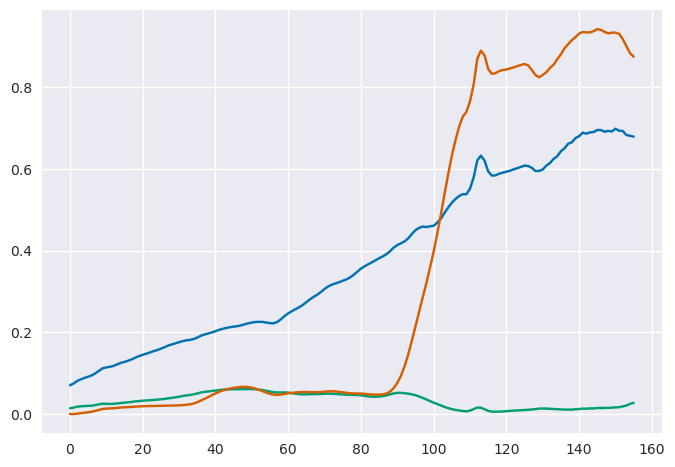

In [5]:
from HySpecLab.eea import VCA
n_endmembers = dataset.n_endmembers + 0

vca = VCA(n_endmembers=n_endmembers, snr_input=1, random_state=42)

E = vca.fit(dataset.X.numpy())
endmember_init = torch.from_numpy(vca.endmembers()).float()
# forces that the max value of each ealemend is 1 - 1e-3, For testing!!
# endmember_init = (endmember_init / endmember_init.max(dim=1, keepdim=True)[0]) * .9
logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))


with plt.style.context(("seaborn-colorblind")):
    plt.plot(endmember_init.T)
plt.show()


In [6]:
# from pysptools import eea
# n_endmembers = dataset.n_endmembers + 25

# ee = eea.NFINDR()
# endmember = ee.extract(dataset.image().numpy(), n_endmembers)
# endmember_init = torch.from_numpy(endmember).float()
# logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))

# with plt.style.context(("seaborn-colorblind")):
#     plt.plot(endmember_init.T)
# plt.show()

In [7]:
# n_endmembers = dataset.n_endmembers + 0

# ee = eea.FIPPI()
# endmember = ee.extract(dataset.image().numpy(), n_endmembers-1)
# endmember_init = torch.from_numpy(endmember).float()
# endmember_init = endmember_init[1:]
# logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))

# with plt.style.context(("seaborn-colorblind")):
#     plt.plot(endmember_init.T)
# plt.show()



In [8]:
n_bands = dataset.n_bands
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
# train(model, n_endmembers, dataset, n_batchs=32, n_epochs=100, lr=1e-3)
train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3)

100%|██████████| 50/50 [00:28<00:00,  1.73epoch/s, tls=0.1011]


In [9]:
criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

In [10]:
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.0246) tensor(0.4415) tensor(22.9521) tensor(0.2877)


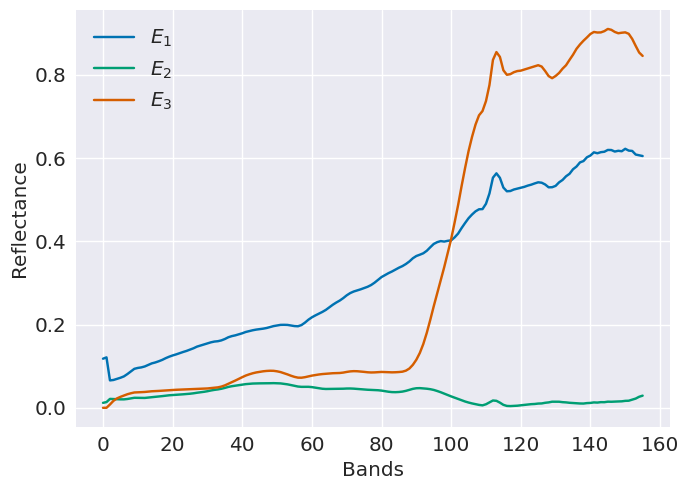

In [11]:
labels = list(map(lambda x: f'$E_{x}$', range(1, n_endmembers+1)))
ebk = sigmoid(model.ebk).detach().cpu()
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(7, 5))
    plt.plot(ebk.T, label=labels)
    plt.ylabel('Reflectance', fontsize='x-large')
    plt.xlabel('Bands', fontsize='x-large')
    #legend background white
    plt.legend(fontsize='x-large', facecolor='white')
    plt.xticks(fontsize='x-large')
    plt.yticks(fontsize='x-large')
    plt.tight_layout()
    
plt.show()

In [12]:
# ordering the endmembers
endmembers = dataset.endmembers().detach().cpu()
from HySpecLab.metrics import sad
sad_result = sad(ebk, endmembers)
print(sad_result)
idx = torch.argmin(sad_result, dim=1) # Index for reordering the ground truth
print(idx)

# reorder the endmembers
endmembers = endmembers[idx]

tensor([[0.0368, 0.3874, 0.8304],
        [0.8540, 1.2273, 0.1292],
        [0.3990, 0.0359, 1.1488]])
tensor([0, 2, 1])


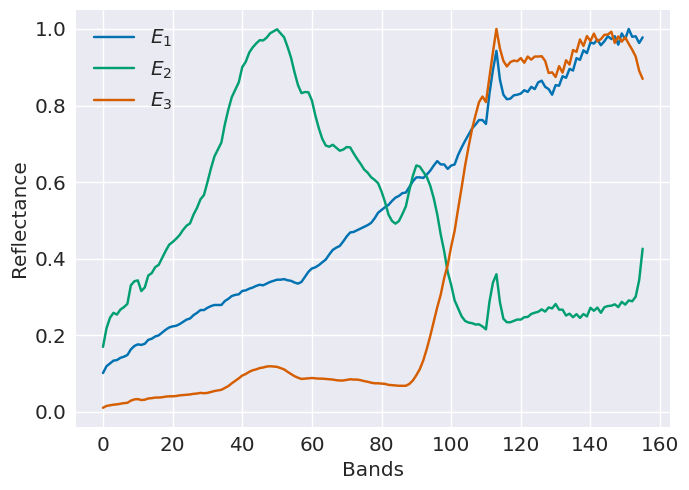

In [13]:
labels = list(map(lambda x: f'$E_{x}$', range(1, len(dataset.endmembers())+1)))
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(7, 5))
    plt.plot(endmembers.T, label=labels)
    plt.ylabel('Reflectance', fontsize='x-large')
    plt.xlabel('Bands', fontsize='x-large')
    plt.legend(fontsize='x-large', facecolor='white')
    plt.xticks(fontsize='x-large')
    plt.yticks(fontsize='x-large')
    # plt.title('Ground Truth', fontsize='x-large')
    plt.tight_layout()
    plt.show()

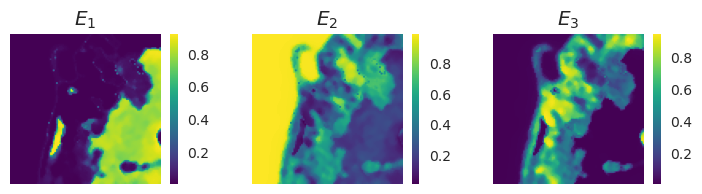

In [14]:
from torch.nn.functional import softmax
test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, n_endmembers)
labels = list(map(lambda x: f'$E_{x}$', range(1, n_endmembers+1)))

# with plt.style.context(("seaborn-colorblind")):
fig = plt.figure(figsize=(12,7))
for i in range(n_endmembers):
    plt.subplot(4,5,i+1)
    # plt.imshow(test[:,:,i].T, vmin=0, vmax=softmax(model.A, dim=1).max(), cmap='viridis')
    plt.imshow(test[:,:,i].T, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i], fontsize='x-large')
    plt.colorbar()

plt.tight_layout()
plt.show()

In [15]:
ebk = sigmoid(model.ebk).detach().cpu()
endmembers = dataset.endmembers()

from torch.nn.functional import mse_loss
def rmse(x: torch.Tensor, y: torch.Tensor):
    return torch.sqrt(mse_loss(x, y, reduction='none').mean(dim=1))

abundance = softmax(model.A.detach(), dim=1).cpu().reshape(dataset.n_row, dataset.n_col, n_endmembers)
abundance = abundance.permute(2,0,1)
abundance_gt = dataset.abundance()[:,:,idx].permute(2,0,1) # Reorder the ground truth
endmember_gt = dataset.endmembers()[idx, :]

rmse_result = rmse(abundance.flatten(1), abundance_gt.flatten(1))
print(rmse_result)

tensor([0.2306, 0.3862, 0.2232])


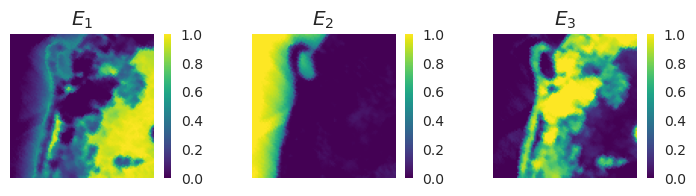

In [16]:
fig = plt.figure(figsize=(12,7))
for i in range(n_endmembers):
    plt.subplot(4,5,i+1)
    # plt.imshow(test[:,:,i].T, vmin=0, vmax=softmax(model.A, dim=1).max(), cmap='viridis')
    plt.imshow(abundance_gt[i,:,:].T, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i], fontsize='x-large')
    plt.colorbar()

plt.tight_layout()
plt.show()

# Urban dataset

In [11]:
from dataset import HSIDataset
from torch import tensor
import scipy.io as sio

class Urban(HSIDataset):
    def __init__(self, root_dir, transform=None):
        super(Urban, self).__init__()

        data = sio.loadmat(os.path.join(root_dir, 'Urban_R162.mat'))
        # y = sio.loadmat(os.path.join(root_dir, 'groundTruth/end4_groundTruth.mat'))
        y = sio.loadmat(os.path.join(root_dir, 'groundTruth_Urban_end5/end5_groundTruth.mat'))
        # y = sio.loadmat(os.path.join(root_dir, 'groundTruth_Urban_end6/end6_groundTruth.mat'))

        self.n_row, self.n_col = data['nRow'].item(), data['nCol'].item()

        self.X = data['Y'].T.reshape(self.n_row, self.n_col, -1) # (nRow, nCol, nBand)
        self.X = self.preprocessing(self.X).reshape(-1, self.X.shape[-1]) # (nRow*nCol, nBand)
        self.X = tensor(self.X, dtype=torch.float32)

        self.E = tensor(y['M'].T, dtype=torch.float32) # (nEndmember, nBand)
        self.A = tensor(y['A'].T, dtype=torch.float32) # (nRow*nCol, nEndmember)
        self.n_endmembers = self.E.shape[0]
        self.n_bands = self.E.shape[1] 

        self.transform = transform

    def __len__(self):
        return self.n_row * self.n_col

    def __getitem__(self, idx):
        sample = self.X[idx]
        if self.transform:
            sample = self.transform(sample)

        return sample

    def endmembers(self):
        return self.E

    def abundance(self):
        return self.A.reshape(self.n_row, self.n_col, -1)

    def image(self):
        return self.X.reshape(self.n_row, self.n_col, -1)

In [12]:
dataset = Urban(root_dir=config.Urban_PATH)

1


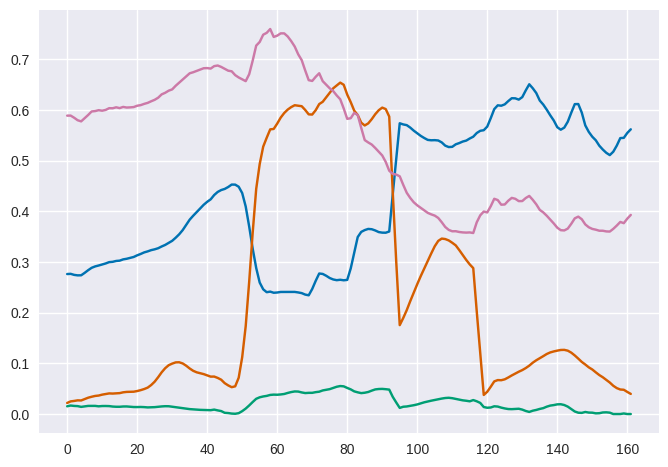

In [26]:
from HySpecLab.eea import VCA
n_endmembers = dataset.n_endmembers - 1
endmembers = dataset.endmembers()

from HySpecLab.metrics import sad
import numpy as np
for i in range(256):
    vca = VCA(n_endmembers=n_endmembers, snr_input=1, random_state=i)

    E = vca.fit(dataset.X.numpy())
    endmember_init = torch.from_numpy(vca.endmembers()).float()

    sad_result = sad(endmember_init, endmembers)
    idx = torch.argmin(sad_result, dim=1) # Index for reordering the ground truth
    if np.unique(idx).shape[0] == n_endmembers:
        print(i)
        break

# vca = VCA(n_endmembers=n_endmembers, snr_input=1, random_state=214)

# E = vca.fit(dataset.X.numpy())
# endmember_init = torch.from_numpy(vca.endmembers()).float()

# forces that the max value of each ealemend is 1 - 1e-3, For testing!!
# endmember_init = (endmember_init / endmember_init.max(dim=1, keepdim=True)[0]) * .9
logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))


with plt.style.context(("seaborn-colorblind")):
    plt.plot(endmember_init.T)
plt.show()

In [27]:
i

1

In [28]:
n_bands = dataset.n_bands
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
# train(model, n_endmembers, dataset, n_batchs=32, n_epochs=100, lr=1e-3)
train(model, n_endmembers, dataset, n_batchs=50, n_epochs=100, lr=1e-3)

100%|██████████| 100/100 [00:53<00:00,  1.86epoch/s, tls=0.1320]


In [29]:
criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

In [30]:
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.0388) tensor(0.6530) tensor(83.6216) tensor(0.3691)


In [31]:
volume_reg(endmember_init)

tensor(197.2809)

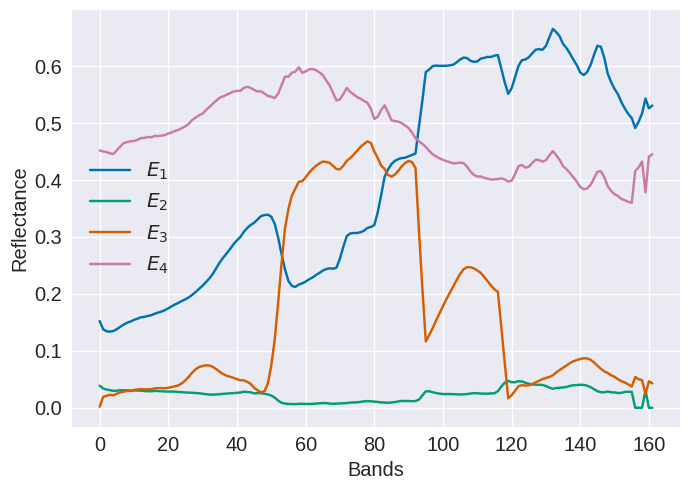

In [32]:
labels = list(map(lambda x: f'$E_{x}$', range(1, n_endmembers+1)))
ebk = sigmoid(model.ebk).detach().cpu()
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(7, 5))
    plt.plot(ebk.T, label=labels)
    plt.ylabel('Reflectance', fontsize='x-large')
    plt.xlabel('Bands', fontsize='x-large')
    #legend background white
    plt.legend(fontsize='x-large')
    plt.xticks(fontsize='x-large')
    plt.yticks(fontsize='x-large')
    plt.tight_layout()
    
plt.show()

In [33]:
# ordering the endmembers
endmembers = dataset.endmembers().detach().cpu()
from HySpecLab.metrics import sad
sad_result = sad(ebk, endmembers)
print(sad_result)
idx = torch.argmin(sad_result, dim=1) # Index for reordering the ground truth
print(idx)

# idx[1] = 1
idx[-2] = 1

# reorder the endmembers
endmembers = endmembers[idx]



tensor([[0.2427, 0.6472, 0.8720, 0.6509, 0.2569],
        [0.4358, 0.9180, 1.1095, 0.5577, 0.5251],
        [0.7788, 0.2505, 0.0863, 0.7807, 0.6865],
        [0.2983, 0.5466, 0.6966, 0.1552, 0.3008]])
tensor([0, 0, 2, 3])


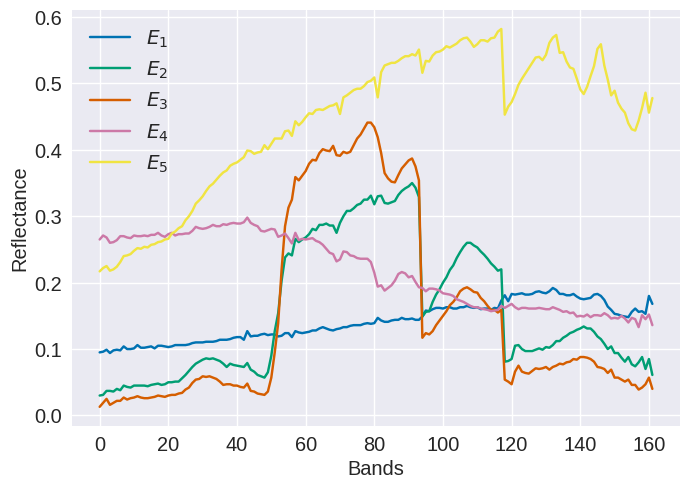

In [34]:
labels = list(map(lambda x: f'$E_{x}$', range(1, len(dataset.endmembers())+1)))
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(7, 5))
    plt.plot(dataset.endmembers().T, label=labels)
    plt.ylabel('Reflectance', fontsize='x-large')
    plt.xlabel('Bands', fontsize='x-large')
    plt.legend(fontsize='x-large', facecolor='white')
    plt.xticks(fontsize='x-large')
    plt.yticks(fontsize='x-large')
    # plt.title('Ground Truth', fontsize='x-large')
    plt.tight_layout()
    plt.show()

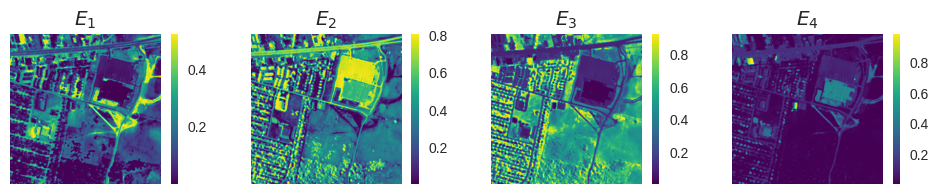

In [35]:
from torch.nn.functional import softmax
test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, n_endmembers)
labels = list(map(lambda x: f'$E_{x}$', range(1, n_endmembers+1)))

# with plt.style.context(("seaborn-colorblind")):
fig = plt.figure(figsize=(12,7))
for i in range(n_endmembers):
    plt.subplot(4,5,i+1)
    # plt.imshow(test[:,:,i].T, vmin=0, vmax=softmax(model.A, dim=1).max(), cmap='viridis')
    plt.imshow(test[:,:,i].T, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i], fontsize='x-large')
    plt.colorbar()

plt.tight_layout()
plt.show()

In [33]:
ebk = sigmoid(model.ebk).detach().cpu()
endmembers = dataset.endmembers()
print(endmembers.shape)

from torch.nn.functional import mse_loss
def rmse(x: torch.Tensor, y: torch.Tensor):
    return torch.sqrt(mse_loss(x, y, reduction='none').mean(dim=1))

abundance = softmax(model.A.detach(), dim=1).cpu().reshape(dataset.n_row, dataset.n_col, n_endmembers)
abundance = abundance.permute(2,0,1)
abundance_gt = dataset.abundance()[:,:,idx].permute(2,0,1) # Reorder the ground truth
print(abundance_gt.shape)
endmember_gt = dataset.endmembers()[idx, :]

rmse_result = rmse(abundance.flatten(1), abundance_gt.flatten(1))
print(rmse_result)

torch.Size([4, 162])
torch.Size([4, 307, 307])
tensor([0.1918, 0.4387, 0.2516, 0.2942])


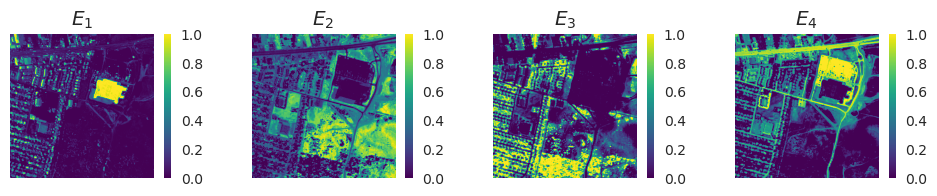

In [34]:
fig = plt.figure(figsize=(12,7))
for i in range(n_endmembers):
    plt.subplot(4,5,i+1)
    # plt.imshow(test[:,:,i].T, vmin=0, vmax=softmax(model.A, dim=1).max(), cmap='viridis')
    plt.imshow(abundance_gt[i,:,:].T, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i], fontsize='x-large')
    plt.colorbar()

plt.tight_layout()
plt.show()

In [59]:
dataset.endmembers().shape

torch.Size([4, 162])

# Cuprite

In [15]:
from dataset import HSIDataset
from torch import tensor
import scipy.io as sio

class Cuprite(HSIDataset):
    def __init__(self, root_dir, transform=None):
        super(Cuprite, self).__init__()

        data = sio.loadmat(os.path.join(root_dir, 'CupriteS1_R188.mat'))
        y = sio.loadmat(os.path.join(root_dir, 'groundTruth_Cuprite_end12/groundTruth_Cuprite_nEnd12.mat'))

        self.n_row, self.n_col = data['nRow'].item(), data['nCol'].item()

        self.X = data['Y'].T.reshape(self.n_row, self.n_col, -1) # (nRow, nCol, nBand)
        self.X = self.preprocessing(self.X, max_value=2**16).reshape(-1, self.X.shape[-1]) # (nRow*nCol, nBand)
        self.X = tensor(self.X, dtype=torch.float32)

        self.E = tensor(y['M'].T, dtype=torch.float32) # (nEndmember, nBand)
        # self.A = tensor(y['A'].T, dtype=torch.float32) # (nRow*nCol, nEndmember)
        self.n_endmembers = self.E.shape[0]
        self.n_bands = self.E.shape[1] 

        self.transform = transform

    def __len__(self):
        return self.n_row * self.n_col

    def __getitem__(self, idx):
        sample = self.X[idx]
        if self.transform:
            sample = self.transform(sample)

        return sample

    def endmembers(self):
        return self.E

    def abundance(self):
        return None

    def image(self):
        return self.X.reshape(self.n_col, self.n_row, -1)

In [16]:
dataset = Cuprite(config.Cuprite_PATH)

(-0.5, 249.5, 189.5, -0.5)

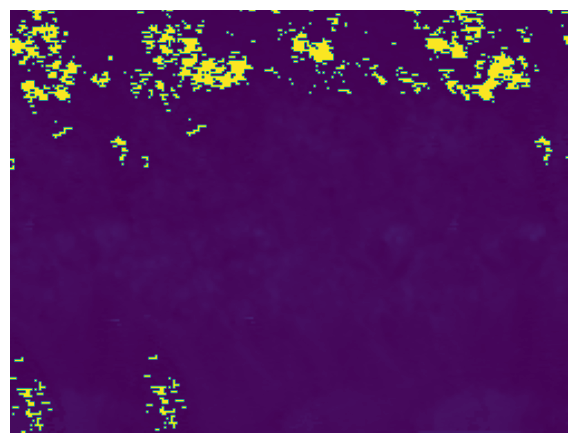

In [19]:
plt.imshow(dataset.image()[:,:,1], cmap='viridis')
plt.axis('off')


In [20]:
data['Y']

NameError: name 'data' is not defined

In [6]:
2**16

65536

In [21]:
import scipy.io as sio
data = sio.loadmat(os.path.join('/home/abian/Data/Dataset/HSI/Cuprite/', 'CupriteS1_R188.mat'))

data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'SlectBands', 'nRow', 'nCol', 'nBand', 'Y'])

In [38]:
import numpy as np
X = data['Y'] / 2**16

In [44]:
data['Y'].T.reshape(data['nRow'], data['nCol'], -1)

TypeError: only integer scalar arrays can be converted to a scalar index

In [33]:
X.shape

(188, 47500)

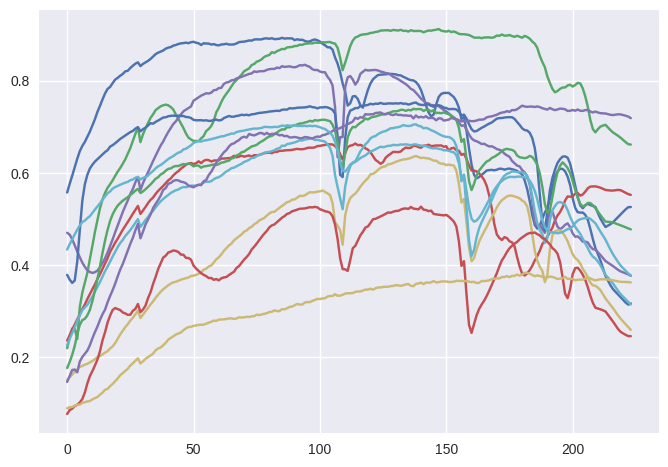

In [25]:
data = sio.loadmat(os.path.join('/home/abian/Data/Dataset/HSI/Cuprite', 'groundTruth_Cuprite_end12/groundTruth_Cuprite_nEnd12.mat'))
from matplotlib import pyplot as plt
plt.plot(data['M'])


In [20]:
data['M'].shape

(224, 12)